## Dyna planning

#### Background

The aim of this part of the assignment is to introduce you to the concept of Dyna (Sutton, 1990). By now you will have heard about model-free (MF) and model-based (MB) approaches to control. MF algorithms learn and store estimates of the state-action value function. This means that control simply involves retrieving those cached value estimates and choosing among the available actions by comparing their worth. MB control, on the other hand, involves the use of a model to calculate those values. In the RL literature this is typically known as planning. Planning has the advantage of affording behavioural flexibility, since once a change in the world is discovered the model can be updated and the values re-calculated in a way that reflects the global knowledge of the environment. By contrast, MF algorithms need many experiences to propagate the information about the change to other states.

Dyna (Sutton, 1990) is an integrated architecture which combines the merits of MF and MB approaches. Whilst interacting with the environment (i.e., being online), Dyna learns MF state-action values as well as a model of its environment (in the most general sense this involves both the transition and reward models). Whilst not interacting with the environment (i.e., being offline -- this can be in between consecutive moves or episodes, or during the equivalent of sleep in animals), Dyna uses its learnt model to additinally train the MF values. That is, the model now acts as a simulator of the environment and provides additional experiences for learning. This means that at decision time Dyna is fast to react, since it acts according to an MF policy by simply retrieving the relevant values; however, those values have been trained by a model and therefore contain some portion of the global knowledge of the environment collected so far.

One particularly critical aspect of learning is exploration, and in fact Dyna's original motivation was to improve the efficiency of exploration. You are invited to read the original paper by Sutton (1990) to familiarise yourself with the idea and the sort of problems it attempts to solve. The pdf of the paper can be found in the `papers` folder of this repository.

#### Task 1 [10 marks]

The first part of the assignment is to reproduce some of the results from the original Dyna paper (Sutton, 1990). In particular, **your task is to generate and visualise data plotted in figure 6** in that paper. You can neglect Dyna-PI and only implement Dyna-$Q$- and Dyna-$Q$+.

To make your life a little easier, and to let you jump right into the more interesting stuff, you are provided with the environment simulator located in `environment.py`, as well as a blueprint of the main code for the agent. That is, you have access to the file `agent.py` where you will find the `DynaAgent` class. This class has a method called `simulate` with the main simulation loop already implemented.

**Your task is to fill in the missing implementation** in the `agent.py` file. Thus, you are tasked to complete the following functions:
- `_policy`. This is the typical $\pi(a\mid s)$ which specifies how the agent chooses actions in any given state
- `_update_qvals`. This is the $Q$-value update rule
- `_update_experience_buffer`. This updates the agent's experience buffer from which it then samples planning updates
- `_update_action_count`. This counts the number of moves elapsed since each action has last been attempted
- `_plan`. This is the function which lets the agent plan

Once that's done you can run the code below which will hopefully reproduce the figure

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from write_load import load_env
from agent import DynaAgent, MyDynaAgent

In [2]:
# load environments
maze_conf_path = os.path.abspath(os.path.join(os.getcwd(), '..', 'envs'))
maze1_conf = load_env(os.path.join(maze_conf_path, 'dyna1.txt')) # maze with only the right path open 
maze2_conf = load_env(os.path.join(maze_conf_path, 'dyna2.txt')) # maze with both paths open

In [3]:
# initialise the agents
# note that alpha is the learning rate (instead of beta as in the paper)
dyna_qplus  = DynaAgent(alpha=0.5, gamma=0.9, epsilon=0.001)
dyna_qminus = DynaAgent(alpha=0.5, gamma=0.9, epsilon=0)
mydyna  = MyDynaAgent(alpha=0.5, gamma=0.9, epsilon=0.001)

In [4]:
np.random.seed(2)
# run simulations
num_trials = 3000
num_runs   = 50
perf       = [np.zeros((num_runs, num_trials*2)), np.zeros((num_runs, num_trials*2)), np.zeros((num_runs, num_trials*2))]
agents     = [dyna_qplus, dyna_qminus, mydyna]

for idx_agent, agent in enumerate(agents):
    for idx_run in range(num_runs):
        agent.init_env(**maze1_conf)
        agent.simulate(num_trials=num_trials, reset_agent=True, num_planning_updates=10)
        # world change
        agent.init_env(**maze2_conf)
        agent.simulate(num_trials=num_trials, reset_agent=False, num_planning_updates=10)
        # save performance
        perf[idx_agent][idx_run, :] = agent.get_performace()
        if (idx_run+1)%10 == 0:
            print('done with run %u/%u'%(idx_run+1, num_runs))

# average cumulative reward
avg_perf_dyna_qplus  = np.mean(perf[0], axis=0)
avg_perf_dyna_qminus = np.mean(perf[1], axis=0)
avg_perf_mydyna = np.mean(perf[2], axis=0)

done with run 10/50
done with run 20/50
done with run 30/50
done with run 40/50
done with run 50/50
done with run 10/50
done with run 20/50
done with run 30/50
done with run 40/50
done with run 50/50
done with run 10/50
done with run 20/50
done with run 30/50
done with run 40/50
done with run 50/50


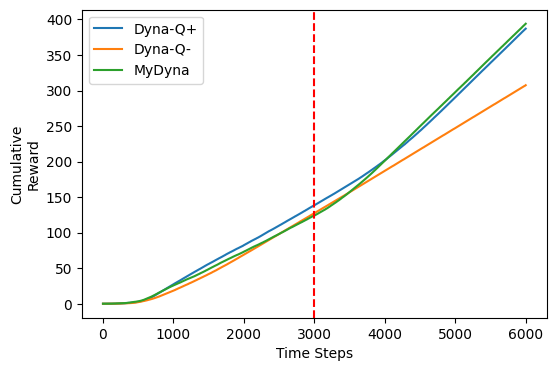

In [5]:
# plot Figure 6 from Sutton (1990) here
plt.figure(figsize=(6, 4))
plt.plot(avg_perf_dyna_qplus,  label='Dyna-Q+')
plt.plot(avg_perf_dyna_qminus, label='Dyna-Q-')
plt.plot(avg_perf_mydyna, label='MyDyna')
plt.axvline(3000, linestyle='--', c='r')
plt.xlabel("Time Steps")
plt.ylabel("Cumulative\nReward")
plt.legend()
plt.show()

Describe in your own words the apparent differences you observe in the above plot. Some of those differences involve the particular choice of the exploration bonus used in this algorithm. Suggest and implement another sensible exploration bonus and compare the performance of your agent against Dyna-$Q$+ and Dyna-$Q$-. Explain your choice. 

For the Dyna-Q- agent, after around 1000 time steps, the cumulative reward per time step (slope of the cumulative reward) stays constant, which idicates that the agent learned to take a path to which it sticks. Even after time step 3000, when the shortcut is added, the agent does not change its strategy, indicating that it is unable to learn the shortcut. The Dyna-Q+ Agent on the other hand exhibits an increase in slope shortly after the shortcut is added, indicating that the agent found a shorter path. The Dyna-Q+ agent also seems to learn the goal faster, since it reaches the state of constant slope faster than the Dyna-Q- agent.

For the choice of a new exploration bonus I was trying to think about a way to not only let the agent explore states and actions it has not taken in a long time, but to also make these states and actions dependent on the spatial distance to the states it has recently experienced, such that the states which are further away spatially, get attributed a larger exploration bonus. This is implemented by increasing the action acount by the euklidian distance from the state currently taken. As one can see, the agent is able to learn faster than both Dyna-Q agents, although the path it finds for the maze without shortcut is not ideal. The slope of the cumulative reward is lower than the slope for both Dyna-Q agents. I think the reason for that is that the path is relatively long, and thus the agent gets distracted by actions with large expolartion bonus which lie on its path. For the shortcut this is not the case. One can see that the agent learns the shortcut faster and is even able to make up for the difference in cumulative reward that it lost while learning the long path.

## 2-step task

#### Background

The 2-step task is one of the most iconic RL tasks (Daw et al. 2011). It was designed to dissect the relative contributions of the MF and MB systems in human choices. There are multiple ways in which MB information can enter choice. For instance, as you will have seen in the case of Dyna, the MF values are additionally trained by the MB system during offline behavioural states. In fact, this process of Dyna-style planning parallels closely hippocampal replay which has been suggested to implement MB planning (Mattar \& Daw, 2018).

For the purpose of this exercise, we will assume that the choice is guided by a linear combination of the MF and MB values. Thus, by tweaking the relative contribution of each, you would expect different behaviours to emerge. Classically, the measure of this balance used in the 2-step task is stay probability. That is, the probability that the subject/agent repeats the same first-stage choice conditioned on the outcome of the second stage in the previous trial.

#### Task 2 [20 marks]

For this part of the assigniment, **your task is to reproduce and visualise data plotted in figure 2** in Daw et al. (2011). There is no pre-implemented code for the agent, except for some basics in the `agent.py` file where you can find the `TwoStepAgent` class. Therefore, you have to follow the methodology in the paper and implement it yourself. You can find the relevant paper in the `papers` folder of this git repository. The only provided code is the one below, as well as the `get_stay_probabilities` method.

In [7]:
from agent import TwoStepAgent
from environment import TwoStepEnv
import numpy as np
import matplotlib.pyplot as plt

In [8]:
# initialise the agent. The parameters are taken from the paper
env =   TwoStepEnv()
agent = TwoStepAgent(env, alpha1=0.54, alpha2=0.42, beta1=5.19, beta2=3.69, lam=0.57, w=0.39, p=0.11)
#agent = TwoStepAgent(env, alpha1=0.54, alpha2=0.42, beta1=5.19, beta2=3.69, lam=0.57, w=0, p=0.11)

In [9]:
#np.random.seed(2)
# run simulations
num_trials  = 201
num_averg   = 50#17
stay_probas = np.zeros((num_averg, 4))
for n in range(num_averg):
    agent.simulate(num_trials)
    stay_probas[n, :] = agent.get_stay_probabilities()

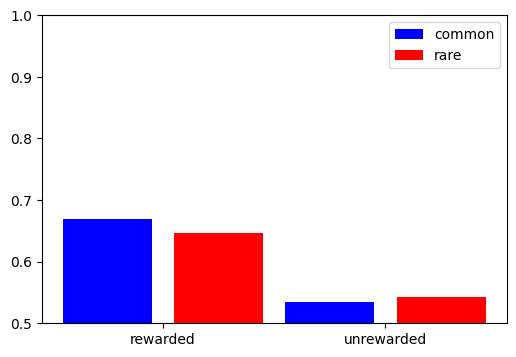

In [10]:
plt.figure(figsize=(6, 4))
plt.bar(1, np.mean(stay_probas[:, 0]), facecolor='blue', label='common')
plt.bar(2, np.mean(stay_probas[:, 1]), facecolor='red', label='rare')
plt.bar(3, np.mean(stay_probas[:, 2]), facecolor='blue')
plt.bar(4, np.mean(stay_probas[:, 3]), facecolor='red')
plt.ylim(0.5, 1)
plt.xticks([1.5, 3.5], ['rewarded', 'unrewarded'])
plt.legend()
plt.show()

Describe in your own words the apparent differences between the MF and MB agents. What do the data plotted with best-fitting parameters tell you about the relative contributions of MF and MB systems to subjects' choices?

Unfortunately the code is not working exactly as it is supposed to according to the paper. If working correctly, the model free algorithm should predict that if a reward is recieved, a repetition of the same actions should lead to a reward again. It therefore shouldnt matter wether the reward was received on a common or rare transition, and if a reward was received, the stay probabilities should be larger. The model based agent knows the transition probabilites and can predict that it can make sense to change its actions even if a reward was received. Also, if it receives no reward on a rare transition it makes more sense to keep the choice taken on the first action to enter the other state.
The weight parameter w determines the ratio between the contributions of the model based and model free agents. A value of 0.39 means that the model free agent has a slightly higher impact than the model based agent.